## Import Library

Tahap ini bertujuan untuk mengimpor semua library Python yang diperlukan untuk analisis data, pemodelan recommender system, dan evaluasi. Library seperti pandas digunakan untuk manipulasi data, scikit-learn untuk pemodelan dan metrik, dan matplotlib serta seaborn untuk visualisasi.

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Loading

Pada tahap ini, kita akan memuat dua dataset utama yang akan digunakan: u.data yang berisi informasi rating film oleh pengguna, dan u.item yang berisi detail informasi film seperti judul dan genre.

In [13]:
# Membaca data ratings
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('dataset/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

In [14]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Ini adalah tampilan awal dari dataframe ratings yang berisi ID pengguna, ID film, rating yang diberikan, dan timestamp.

In [15]:
# Membaca data movies
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
genres_legend = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_cols.extend(genres_legend)
movies = pd.read_csv('dataset/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [16]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Ini adalah tampilan awal dari dataframe movies yang berisi informasi detail film, termasuk judul, tanggal rilis, URL IMDb, dan flag untuk setiap genre.

## Data Understanding

Pada tahap pemahaman data, kita akan melakukan eksplorasi awal untuk mendapatkan insight mengenai karakteristik dataset. Ini meliputi melihat jumlah data, distribusi rating, film dengan rating terbanyak, rata-rata rating tertinggi, aktivitas rating pengguna, distribusi genre film, dan korelasi antar genre.

In [17]:
# Jumlah data
print(f"Jumlah total rating: {len(ratings)}")
print(f"Jumlah pengguna unik: {ratings['user_id'].nunique()}")
print(f"Jumlah film unik: {ratings['item_id'].nunique()}")

Jumlah total rating: 100000
Jumlah pengguna unik: 943
Jumlah film unik: 1682


Terdapat 100,000 rating dari 943 pengguna untuk 1682 film.

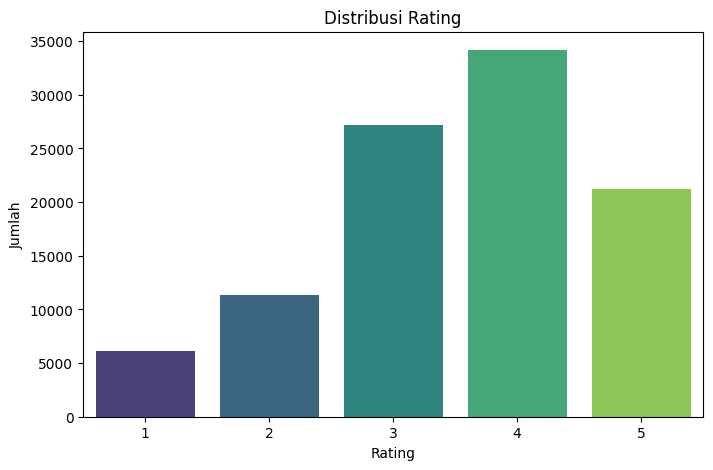

In [18]:
# Distribusi Rating
plt.figure(figsize=(8,5))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Berdasarkan visualisasi distribusi rating, dapat dilihat bahwa rating terbanyak berada pada skala 4, diikuti oleh skala 3 dan 5. Rating dengan skala 1 dan 2 memiliki jumlah yang lebih sedikit.

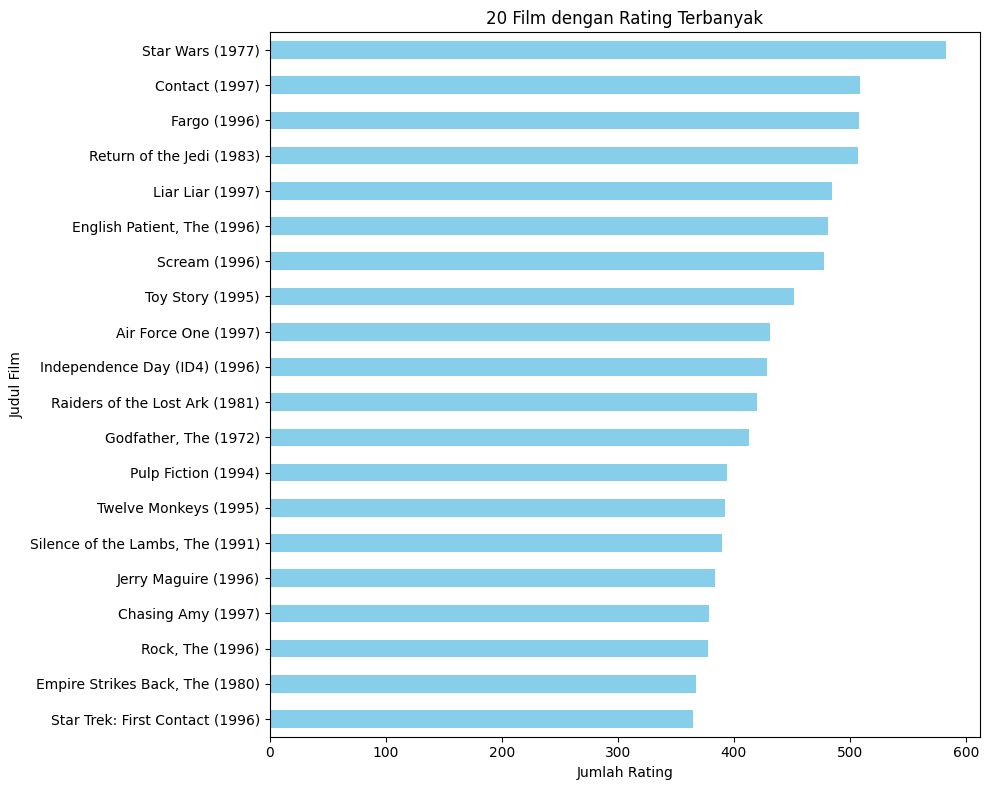

In [19]:
# 20 Film dengan Rating Terbanyak

# Gabungkan data ratings dan judul film
ratings_movies = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')

# Hitung jumlah rating per film
top_rated_movies = ratings_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

# Visualisasi
plt.figure(figsize=(10,8))
top_rated_movies.sort_values().plot(kind='barh', color='skyblue')
plt.title('20 Film dengan Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.tight_layout()
plt.show()

Berdasarkan data rating, film "Star Wars (1977)" menjadi film dengan jumlah rating terbanyak, diikuti oleh "Contact (1997)" dan "Fargo (1996)".

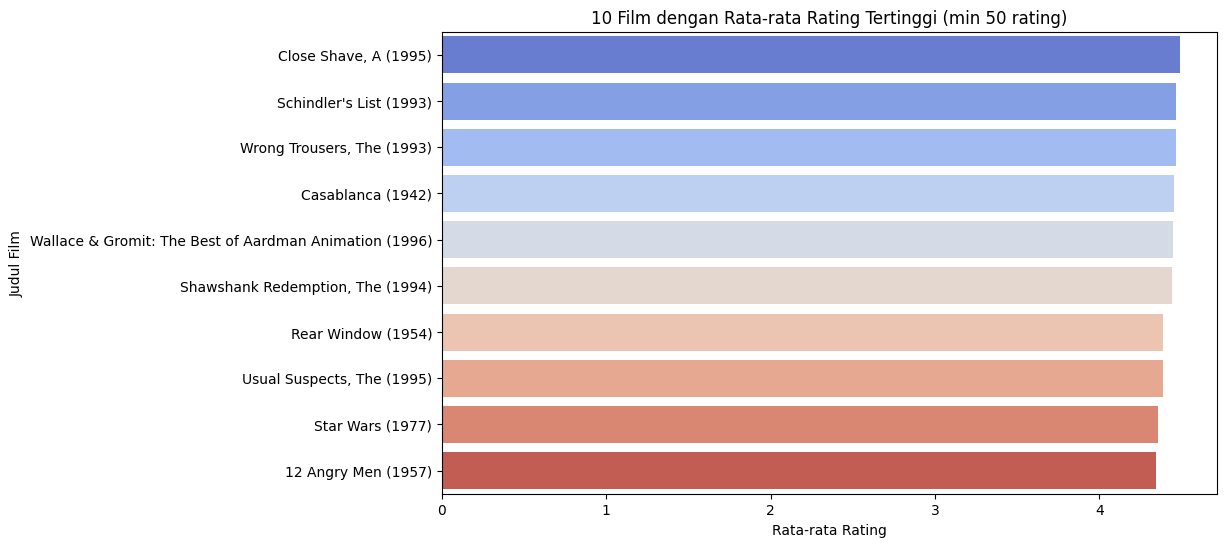

In [20]:
# Rata-rata Rating Tertinggi (Film dengan >=50 rating)

movie_stats = ratings_movies.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'count_rating']
popular_movies = movie_stats[movie_stats['count_rating'] >= 50].sort_values(by='avg_rating', ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(data=popular_movies.reset_index(), x='avg_rating', y='title', palette='coolwarm')
plt.title('10 Film dengan Rata-rata Rating Tertinggi (min 50 rating)')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Judul Film')
plt.show()

Berdasarkan rata-rata rating dengan minimal 50 rating, film "12 Angry Men (1957)" dan "Close Shave, A (1995)" menduduki peringkat teratas, diikuti oleh film-film klasik seperti "Star Wars (1977)", "Usual Suspects, The (1995)", dan "Schindler's List (1993)".

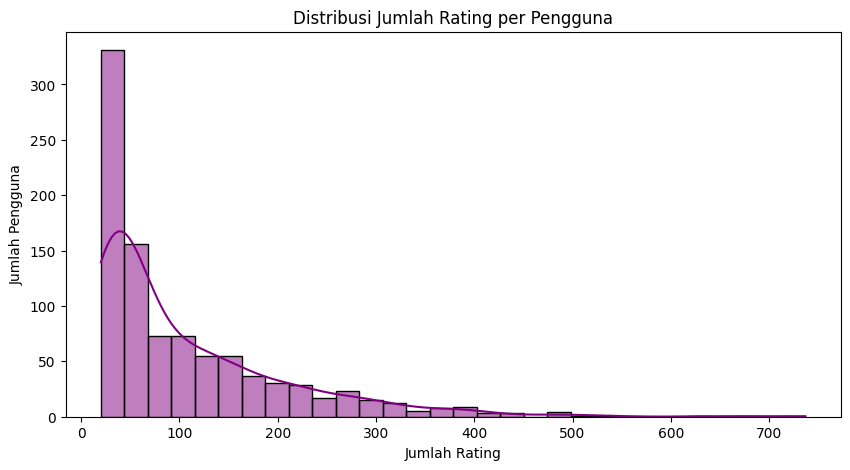

In [21]:
# Aktivitas Rating Pengguna
user_activity = ratings['user_id'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(user_activity, bins=30, kde=True, color='purple')
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Pengguna')
plt.show()

Visualisasi distribusi jumlah rating per pengguna menunjukkan bahwa sebagian besar pengguna memberikan rating dalam jumlah yang relatif kecil, dengan penurunan jumlah pengguna seiring dengan bertambahnya jumlah rating yang mereka berikan. Distribusi ini cenderung miring ke kanan (right-skewed).

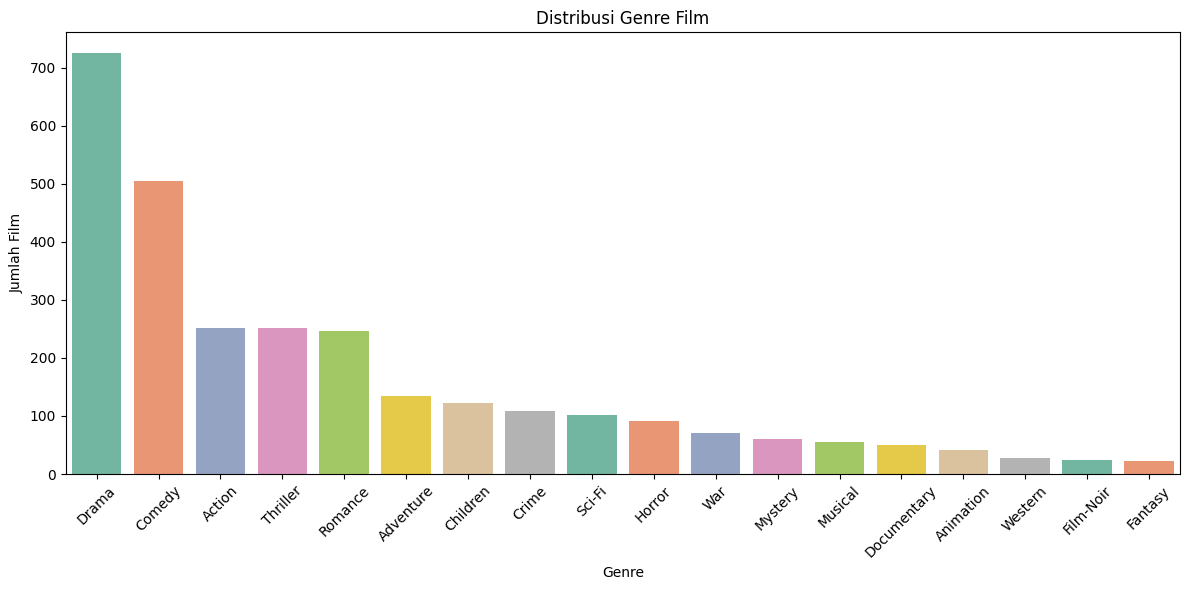

In [22]:
# Distribusi Genre Film

# Mengambil kolom genre aktual dari movies dataframe
genre_columns_from_movies = genres_legend[1:] # Exclude 'unknown'
movies['genre_string_for_analysis'] = movies[genre_columns_from_movies].apply(lambda x: '|'.join(x[x==1].index), axis=1)

# Pisahkan genre untuk analisis
genre_explode = movies[['movie_id', 'genre_string_for_analysis']].copy()
genre_explode = genre_explode.assign(genre=genre_explode['genre_string_for_analysis'].str.split('|')).explode('genre')
genre_explode = genre_explode[genre_explode['genre'] != ''] # Remove empty strings if any

# Visualisasi
plt.figure(figsize=(12,6))
sns.countplot(data=genre_explode, x='genre', order=genre_explode['genre'].value_counts().index, palette='Set2')
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Analisis genre
genre_counts = movies[genre_columns_from_movies].sum().sort_values(ascending=False)
print("\nTop 10 Genre Terpopuler:")
for i, (genre, count) in enumerate(genre_counts.head(10).items(), 1):
    print(f"{i:2d}. {genre}: {count} film")


Top 10 Genre Terpopuler:
 1. Drama: 725 film
 2. Comedy: 505 film
 3. Action: 251 film
 4. Thriller: 251 film
 5. Romance: 247 film
 6. Adventure: 135 film
 7. Children: 122 film
 8. Crime: 109 film
 9. Sci-Fi: 101 film
10. Horror: 92 film


Berdasarkan visualisasi distribusi genre film, genre "Drama" memiliki jumlah film terbanyak, diikuti oleh "Comedy" dan "Action". Beberapa genre seperti "Fantasy" dan "unknown" memiliki jumlah film yang paling sedikit dalam dataset ini.

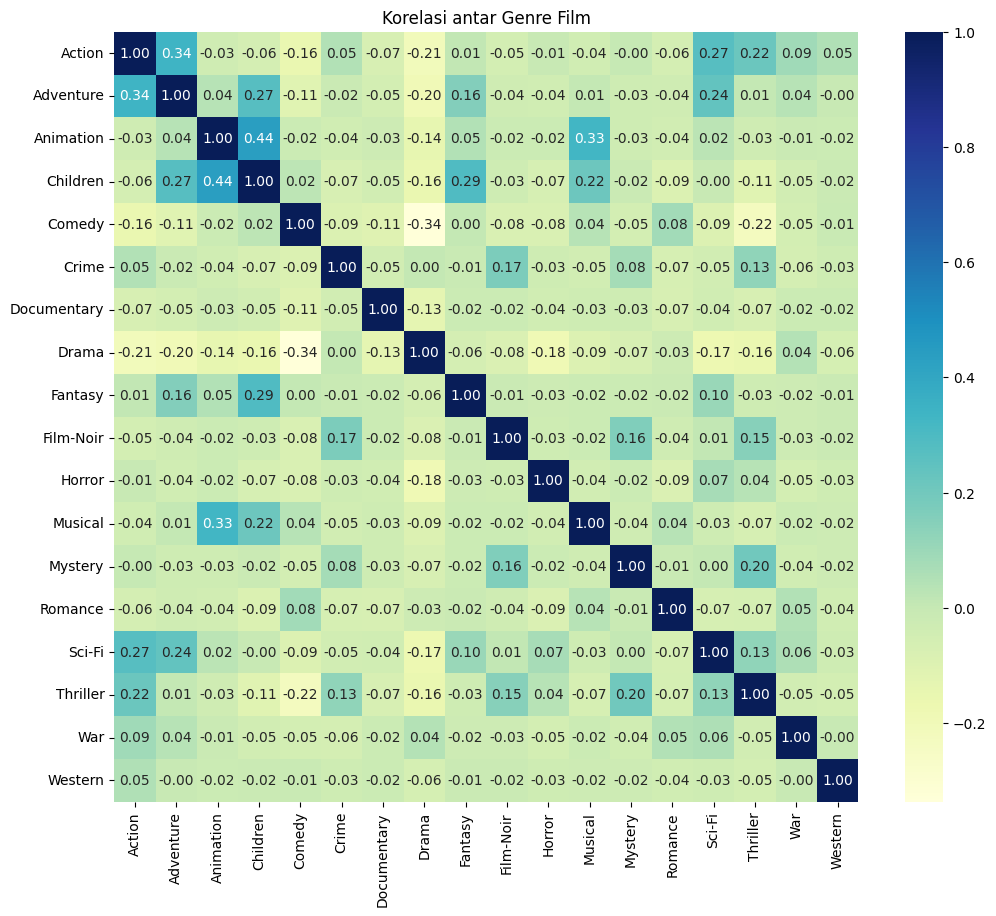

In [24]:
# Korelasi Rating antar Genre
# Menggunakan genre_columns_from_movies untuk memastikan konsistensi
genre_matrix = movies[genre_columns_from_movies].corr()

plt.figure(figsize=(12,10))
sns.heatmap(genre_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Korelasi antar Genre Film')
plt.show()

Heatmap ini menggambarkan hubungan korelasi antara berbagai genre film dalam dataset.

## Data Preparation

Tahap persiapan data melibatkan penggabungan dataset yang relevan dan pembuatan fitur yang diperlukan untuk pemodelan. Untuk content-based filtering, kita akan membuat representasi string dari genre film. Untuk collaborative filtering, kita akan membuat user-item matrix dan membagi data menjadi set pelatihan dan pengujian.

In [26]:
# Membuat genre string untuk content-based filtering
movies['genre_string_for_tfidf'] = '' # Kolom baru untuk TF-IDF
for idx, row in movies.iterrows():
    active_genres = []
    for genre_col_name in genre_columns_from_movies:
        if row[genre_col_name] == 1:
            active_genres.append(genre_col_name)
    movies.at[idx, 'genre_string_for_tfidf'] = ' '.join(active_genres)

In [27]:
# Statistik film dengan genre
movies_with_genres = movies[movies['genre_string_for_tfidf'] != ''].copy()
print(f"Film dengan genre (untuk TF-IDF): {len(movies_with_genres):,}")
print(f"Film tanpa genre (untuk TF-IDF): {len(movies) - len(movies_with_genres):,}")

Film dengan genre (untuk TF-IDF): 1,680
Film tanpa genre (untuk TF-IDF): 2


Hampir semua film memiliki informasi genre.

In [28]:
# TF-IDF Vectorization untuk genre
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_with_genres['genre_string_for_tfidf'])

# Menghitung cosine similarity
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Membuat mapping judul ke index untuk Content-Based
indices_content_based = pd.Series(movies_with_genres.index, index=movies_with_genres['title']).drop_duplicates()

In [29]:
# Split data ratings untuk evaluasi model Collaborative Filtering
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
print(f"Training data (ratings): {len(train_data):,}")
print(f"Testing data (ratings): {len(test_data):,}")

Training data (ratings): 80,000
Testing data (ratings): 20,000


Data rating dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian.

In [30]:
# Membuat user-item matrix dari keseluruhan data ratings (untuk training SVD)
user_item_matrix_full = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print(f"Full User-item matrix shape (for SVD training): {user_item_matrix_full.shape}")

# Tambahan informasi sparsity dan rata-rata rating per pengguna
print(f"Sparsity matrix user-item: {(user_item_matrix_full == 0).sum().sum() / (user_item_matrix_full.shape[0] * user_item_matrix_full.shape[1]) * 100:.1f}%")
ratings_per_user = ratings.groupby('user_id')['rating'].count()
print(f"Rata-rata rating per pengguna: {ratings_per_user.mean():.0f}\nVariasi rating terendah per user: {ratings_per_user.min()}\nVariasi rating tertinggi per user: {ratings_per_user.max()}")

Full User-item matrix shape (for SVD training): (943, 1682)
Sparsity matrix user-item: 93.7%
Rata-rata rating per pengguna: 106
Variasi rating terendah per user: 20
Variasi rating tertinggi per user: 737


Matriks user-item sangat sparse (93.7% nilai adalah 0), yang umum dalam recommender system. Rata-rata setiap pengguna memberikan sekitar 106 rating.


In [31]:
# Membuat user-item matrix untuk data pelatihan (dari train_data hasil split)
train_user_item_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print(f"Train User-item matrix shape: {train_user_item_matrix.shape}")

Train User-item matrix shape: (943, 1653)


Matriks user-item untuk data pelatihan memiliki 943 baris (pengguna) dan 1653 kolom (film yang muncul di set pelatihan).

In [32]:
# Membuat user-item matrix untuk data pengujian (dari test_data hasil split)
test_user_item_matrix = test_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print(f"Test User-item matrix shape: {test_user_item_matrix.shape}")

Test User-item matrix shape: (940, 1411)


Matriks user-item untuk data pengujian memiliki 940 baris (pengguna) dan 1411 kolom (film yang muncul di set pengujian).

## Modeling

Pada tahap ini, kita akan membangun dua jenis sistem rekomendasi: Content-Based Filtering dan Collaborative Filtering.

### Content-Based Filtering

 Content-based filtering akan merekomendasikan film yang serupa dengan film yang disukai pengguna di masa lalu, berdasarkan deskripsi konten film (dalam kasus ini, genre). Kita akan menggunakan TF-IDF untuk mengekstrak fitur dari genre dan cosine similarity untuk mengukur kemiripan antar film.

In [33]:
# Fungsi rekomendasi content-based
def get_content_recommendations(title, cosine_sim_mtx=cosine_sim_matrix, df_movies=movies_with_genres, idx_map=indices_content_based, top_n=10):
    """
    Memberikan rekomendasi berdasarkan content similarity (genre)
    """
    try:
        if title not in idx_map:
            return f"Film '{title}' tidak ditemukan dalam dataset film yang memiliki genre."

        # Ambil index film dari mapping
        idx = idx_map[title]

        # Ambil vektor similarity untuk film tersebut
        if isinstance(idx, pd.Series): # Jika judul tidak unik dan mapping mengembalikan Series
            idx = idx.iloc[0] 

        sim_scores = list(enumerate(cosine_sim_mtx[idx]))

        # Urutkan berdasarkan similarity score (descending)
        sim_scores = sorted(sim_scores, key=lambda x: float(x[1]), reverse=True)

        # Ambil top N (kecuali diri sendiri di posisi pertama, yaitu sim_scores[0])
        sim_scores = sim_scores[1:top_n + 1]

        # Ambil index film yang disarankan
        movie_indices_rec = [i[0] for i in sim_scores]

        # Ambil data film yang direkomendasikan
        recommendations = df_movies.iloc[movie_indices_rec][['title', 'genre_string_for_tfidf']].copy()
        recommendations['similarity_score'] = [float(score[1]) for score in sim_scores]

        return recommendations

    except Exception as e:
        return f"Terjadi error saat mencari rekomendasi untuk '{title}': {str(e)}"

In [34]:
# Test rekomendasi content-based
test_movie_cb = "Toy Story (1995)"
print(f"\nRekomendasi Content-Based untuk '{test_movie_cb}':")
content_recs = get_content_recommendations(test_movie_cb, top_n=5)
if isinstance(content_recs, pd.DataFrame):
    for i, (_, row) in enumerate(content_recs.iterrows(), 1):
        print(f"{i}. {row['title']}")
        print(f"   Genre: {row['genre_string_for_tfidf']}")
        print(f"   Similarity: {row['similarity_score']:.3f}")
        print()
else:
    print(content_recs)


Rekomendasi Content-Based untuk 'Toy Story (1995)':
1. Aladdin and the King of Thieves (1996)
   Genre: Animation Children Comedy
   Similarity: 1.000

2. Aristocats, The (1970)
   Genre: Animation Children
   Similarity: 0.937

3. Pinocchio (1940)
   Genre: Animation Children
   Similarity: 0.937

4. Sword in the Stone, The (1963)
   Genre: Animation Children
   Similarity: 0.937

5. Fox and the Hound, The (1981)
   Genre: Animation Children
   Similarity: 0.937



### Collaborative Filtering

Collaborative filtering membuat rekomendasi berdasarkan preferensi pengguna lain yang memiliki selera yang mirip. Kita akan menggunakan Singular Value Decomposition (SVD) untuk melakukan matrix factorization pada user-item matrix.

In [35]:
# Menggunakan SVD untuk matrix factorization pada user_item_matrix_full
svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(user_item_matrix_full) 
item_factors = svd.components_ 

In [36]:
# Rekonstruksi matrix rating yang diprediksi
predicted_ratings_svd = np.dot(user_factors, item_factors)
predicted_ratings_df = pd.DataFrame(predicted_ratings_svd,
                                    index=user_item_matrix_full.index,
                                    columns=user_item_matrix_full.columns)

In [37]:
# Fungsi rekomendasi collaborative filtering
def get_collaborative_recommendations(user_id, pred_ratings_df=predicted_ratings_df,
                                      train_matrix=train_user_item_matrix, # Untuk mengecek film yg sudah dirating di training
                                      movies_info_df=movies, top_n=10):

    if user_id not in pred_ratings_df.index:
        return f"User ID {user_id} tidak ditemukan dalam model training."

    # Ambil prediksi rating untuk user_id
    user_predictions = pred_ratings_df.loc[user_id]

    # Ambil film yang belum dirating oleh user di data training
    if user_id in train_matrix.index:
        rated_movies_in_train = train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index.tolist()
    else:
        rated_movies_in_train = []

    all_movie_ids_in_model = pred_ratings_df.columns.tolist() # Film yang ada di model SVD
    unrated_movies_ids = [mid for mid in all_movie_ids_in_model if mid not in rated_movies_in_train]

    # Filter prediksi untuk film yang belum dirating (dan ada di model)
    recommendations_for_unrated = user_predictions[unrated_movies_ids]

    # Sort berdasarkan predicted rating
    recommendations_for_unrated = recommendations_for_unrated.sort_values(ascending=False).head(top_n)

    # Gabungkan dengan informasi film (judul)
    rec_with_titles = []
    for movie_id, pred_rating_val in recommendations_for_unrated.items():
        movie_detail = movies_info_df[movies_info_df['movie_id'] == movie_id]
        if not movie_detail.empty:
            rec_with_titles.append({
                'movie_id': movie_id,
                'title': movie_detail.iloc[0]['title'],
                'predicted_rating': pred_rating_val
            })

    return pd.DataFrame(rec_with_titles)

In [38]:
# Test rekomendasi collaborative filtering
test_user_cf = 1
print(f"\nRekomendasi Collaborative Filtering untuk User {test_user_cf}:")
collab_recs = get_collaborative_recommendations(test_user_cf, top_n=5)
if isinstance(collab_recs, pd.DataFrame):
    for i, (_, row) in enumerate(collab_recs.iterrows(), 1):
        print(f"{i}. {row['title']}")
        print(f"   Predicted Rating: {row['predicted_rating']:.2f}")
        print()
else:
    print(collab_recs)


Rekomendasi Collaborative Filtering untuk User 1:
1. Fargo (1996)
   Predicted Rating: 6.40

2. Toy Story (1995)
   Predicted Rating: 5.11

3. Blues Brothers, The (1980)
   Predicted Rating: 4.63

4. Fish Called Wanda, A (1988)
   Predicted Rating: 4.56

5. Reservoir Dogs (1992)
   Predicted Rating: 4.39



## Evaluation

Pada tahap evaluasi, kita akan mengukur kinerja dari kedua model rekomendasi yang telah dibangun. Untuk content-based filtering, kita akan melihat rata-rata skor similarity dari rekomendasi untuk sampel film. Untuk collaborative filtering, kita akan menggunakan metrik seperti Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), dan Precision@K.

In [39]:
# Evaluasi Content-Based Filtering (Karakteristik Rekomendasi)
def evaluate_content_based_characteristics(sample_titles, top_n=10):
    """
    Mengevaluasi karakteristik rekomendasi content-based:
    - Mean Similarity: Rata-rata skor kesamaan dari item yang direkomendasikan.
    - Coverage: Persentase sampel judul yang berhasil mendapatkan rekomendasi.
    """
    similarity_scores_list = []
    successful_recommendations = 0

    for title in sample_titles:
        recs = get_content_recommendations(title, top_n=top_n) 
        if isinstance(recs, pd.DataFrame) and not recs.empty:
            similarity_scores_list.extend(recs['similarity_score'].values)
            successful_recommendations +=1
        elif isinstance(recs, pd.DataFrame) and recs.empty:
             pass 

    mean_score_val = np.mean(similarity_scores_list) if similarity_scores_list else 0.0
    # Coverage adalah persentase film sampel yang berhasil diberi rekomendasi
    coverage_val = (successful_recommendations / len(sample_titles)) * 100 if sample_titles else 0.0
    
    return round(mean_score_val, 4), round(coverage_val, 1)

In [40]:
# Evaluasi Collaborative Filtering - RMSE & MAE
def evaluate_collaborative_rmse_mae(test_matrix, pred_ratings_df_full):
    """
    Menghitung RMSE dan MAE untuk Collaborative Filtering.
    test_matrix: Matriks user-item dari data tes (aktual).
    pred_ratings_df_full: Matriks user-item hasil prediksi SVD (mencakup semua user dan item dari training).
    """
    actuals_list, predictions_list = [], []

    # Iterasi hanya pada user dan item yang ada di test_matrix
    for user_id_test in test_matrix.index:
        if user_id_test in pred_ratings_df_full.index:
            for item_id_test in test_matrix.columns:
                if item_id_test in pred_ratings_df_full.columns: 
                    actual_rating_val = test_matrix.loc[user_id_test, item_id_test]
                    if actual_rating_val > 0: 
                        actuals_list.append(actual_rating_val)
                        predictions_list.append(pred_ratings_df_full.loc[user_id_test, item_id_test])
    
    if actuals_list: 
        rmse_val = sqrt(mean_squared_error(actuals_list, predictions_list))
        mae_val = mean_absolute_error(actuals_list, predictions_list)
        return round(rmse_val, 4), round(mae_val, 4)
    else:
        return None, None

In [41]:
# Evaluasi Collaborative Filtering - Precision@K
def precision_at_k_user(user_id_eval, pred_ratings_df_full, test_matrix_eval, k_val=10, relevance_threshold=4.0):
    """ Menghitung Precision@k untuk satu pengguna """
    if user_id_eval not in pred_ratings_df_full.index or user_id_eval not in test_matrix_eval.index:
        return None

    user_preds_series = pred_ratings_df_full.loc[user_id_eval]
    user_actuals_series = test_matrix_eval.loc[user_id_eval]

    # Item yang benar-benar dirating oleh pengguna di test set
    rated_items_in_test = user_actuals_series[user_actuals_series > 0].index.tolist()
    if not rated_items_in_test: # Jika pengguna tidak punya rating di test set
        return None 

    # Item yang dianggap relevan oleh pengguna di test set
    relevant_items_in_test = user_actuals_series[user_actuals_series >= relevance_threshold].index.tolist()

    # Daftar item ID yang direkomendasikan
    top_k_recommended_ids = user_preds_series.sort_values(ascending=False).head(k_val).index.tolist()
        
    # Hitung berapa banyak dari top_k_recommended_ids yang ada di relevant_items_in_test
    num_hits = len(set(top_k_recommended_ids) & set(relevant_items_in_test))
    
    return num_hits / k_val if k_val > 0 else 0.0

def average_precision_at_k(pred_ratings_df_full, test_matrix_eval, k_val=10, relevance_threshold=4.0):
    """ Menghitung rata-rata Precision@k untuk semua pengguna di test set """
    precisions_list = []
    for user_id_eval in test_matrix_eval.index: # Iterasi hanya user yang ada di test set
        # Pastikan user juga ada di matriks prediksi (jika tidak, tidak bisa dievaluasi)
        if user_id_eval in pred_ratings_df_full.index:
            p_at_k = precision_at_k_user(user_id_eval, pred_ratings_df_full, test_matrix_eval, k_val=k_val, relevance_threshold=relevance_threshold)
            if p_at_k is not None:
                precisions_list.append(p_at_k)
    
    return round(np.mean(precisions_list), 4) if precisions_list else None

In [42]:
# Menjalankan evaluasi
# Untuk Content-Based, ambil sampel film
sample_movie_titles = movies_with_genres['title'].sample(10, random_state=42).tolist()
cb_mean_sim, cb_coverage = evaluate_content_based_characteristics(sample_movie_titles, top_n=5)

# Untuk Collaborative Filtering
# Gunakan test_user_item_matrix dan predicted_ratings_df
cf_rmse, cf_mae = evaluate_collaborative_rmse_mae(test_user_item_matrix, predicted_ratings_df)
avg_precision_cf = average_precision_at_k(predicted_ratings_df, test_user_item_matrix, k_val=5, relevance_threshold=4.0)

print("\nRingkasan Performa & Karakteristik Model:")
print("--- Collaborative Filtering (SVD) ---")
print(f"- RMSE: {cf_rmse:.3f}" if cf_rmse is not None else "- RMSE: Tidak dapat dihitung (cek data uji)")
print(f"- MAE: {cf_mae:.3f}" if cf_mae is not None else "- MAE: Tidak dapat dihitung (cek data uji)")
print(f"- Precision@5: {avg_precision_cf:.3f}" if avg_precision_cf is not None else "- Precision@5: Tidak dapat dihitung")

print("\n--- Content-Based Filtering (Genre TF-IDF & Cosine Similarity) ---")
print(f"- Rata-rata Skor Similaritas (Karakteristik): {cb_mean_sim:.3f}" if cb_mean_sim is not None else "- Rata-rata Skor Similaritas: Tidak tersedia")
print(f"- Cakupan Rekomendasi pada Sampel Uji: {cb_coverage:.1f}%")



Ringkasan Performa & Karakteristik Model:
--- Collaborative Filtering (SVD) ---
- RMSE: 1.850
- MAE: 1.536
- Precision@5: 0.175

--- Content-Based Filtering (Genre TF-IDF & Cosine Similarity) ---
- Rata-rata Skor Similaritas (Karakteristik): 0.982
- Cakupan Rekomendasi pada Sampel Uji: 100.0%


## Inferensi

Pada tahap inferensi, kita akan menggunakan model yang telah dilatih untuk memberikan rekomendasi kepada pengguna tertentu berdasarkan riwayat rating mereka atau preferensi genre.

In [43]:
# Contoh Inferensi untuk Pengguna Tertentu (misal User ID 1)
target_user_id = 1

# 1. Rekomendasi Collaborative Filtering untuk User target_user_id
print(f"\nRekomendasi Collaborative Filtering untuk User {target_user_id}:")
collab_inference_recs = get_collaborative_recommendations(target_user_id, top_n=3)
if isinstance(collab_inference_recs, pd.DataFrame):
    for i, (_, row) in enumerate(collab_inference_recs.iterrows(), 1):
        print(f"{i}. {row['title']} (Prediksi Rating: {row['predicted_rating']:.2f})")
else:
    print(collab_inference_recs)

# 2. Rekomendasi Content-Based berdasarkan film favorit User target_user_id
user_ratings_target = ratings[ratings['user_id'] == target_user_id].sort_values('rating', ascending=False)

if not user_ratings_target.empty:
    # Ambil film dengan rating tertinggi dari user tersebut
    fav_movie_id_target = user_ratings_target.iloc[0]['item_id']
    # Dapatkan judul film dari movies dataframe
    fav_movie_title_series = movies[movies['movie_id'] == fav_movie_id_target]['title']
    
    if not fav_movie_title_series.empty:
        fav_movie_title_target = fav_movie_title_series.iloc[0]
        print(f"\nFilm dengan rating tertinggi dari User {target_user_id}: '{fav_movie_title_target}'")
        print("Rekomendasi Content-Based berdasarkan film tersebut:")
        content_inference_recs = get_content_recommendations(fav_movie_title_target, top_n=3)
        if isinstance(content_inference_recs, pd.DataFrame):
            for i, (_, row) in enumerate(content_inference_recs.iterrows(), 1):
                print(f"{i}. {row['title']} (Skor Similaritas: {row['similarity_score']:.3f})")
        else:
            print(content_inference_recs)
    else:
        print(f"Judul film untuk item_id {fav_movie_id_target} tidak ditemukan.")
else:
    print(f"User {target_user_id} tidak memiliki riwayat rating untuk mendapatkan rekomendasi berbasis film favorit.")


Rekomendasi Collaborative Filtering untuk User 1:
1. Fargo (1996) (Prediksi Rating: 6.40)
2. Toy Story (1995) (Prediksi Rating: 5.11)
3. Blues Brothers, The (1980) (Prediksi Rating: 4.63)

Film dengan rating tertinggi dari User 1: 'Cinema Paradiso (1988)'
Rekomendasi Content-Based berdasarkan film tersebut:
1. Wings of Desire (1987) (Skor Similaritas: 1.000)
2. Manhattan (1979) (Skor Similaritas: 1.000)
3. American President, The (1995) (Skor Similaritas: 1.000)
